# 原論文

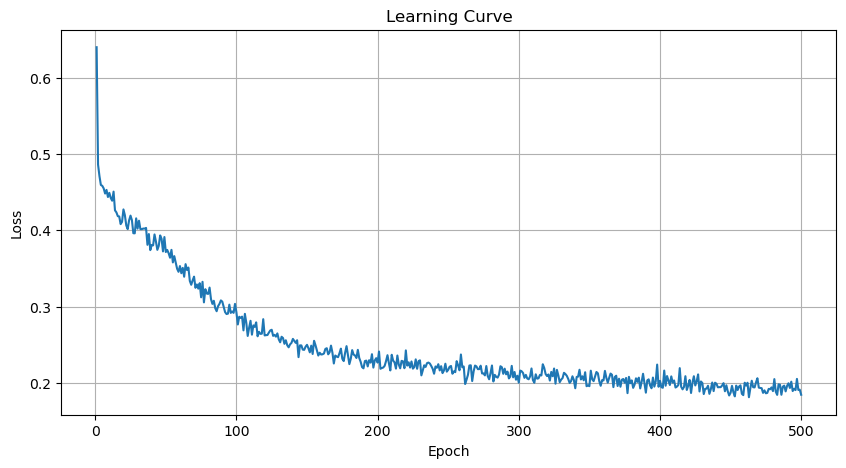


Predicting on test data...


Predicting:   0%|          | 0/7 [00:00<?, ?it/s]


Average score for normal data: 0.1782
Average score for abnormal data: 0.1843


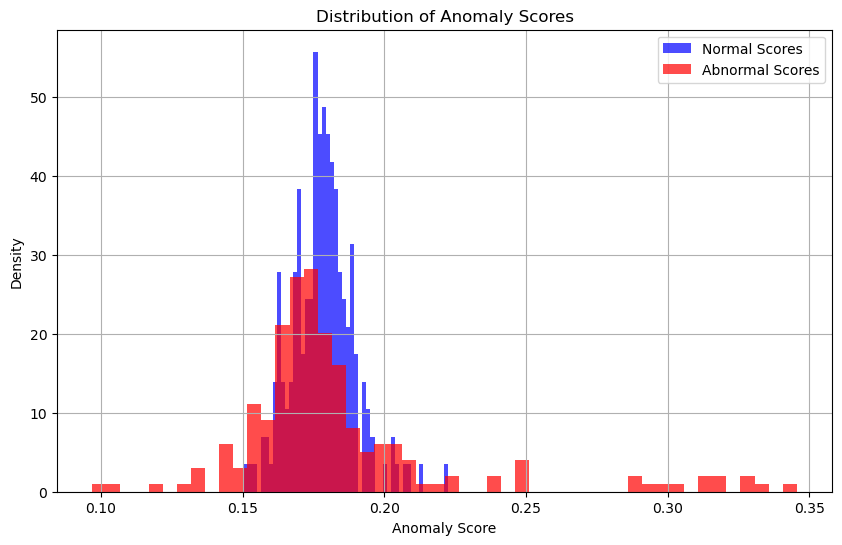

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import random
from tqdm.notebook import tqdm
import math

# 忽略 Matplotlib 的 UserWarning
import warnings
warnings.filterwarnings("ignore")

# ================================================================
#               修正後的 RelativePositionBias Class
# ================================================================
class RelativePositionBias(nn.Module):
    """
    實作論文中提到的相對位置偏置 (Relative Position Bias) 。
    這是一個可學習的查詢表，根據查詢(Query)和鍵(Key)之間的相對距離來提供偏置。
    """
    def __init__(self, num_heads, max_relative_position):
        super().__init__()
        self.num_heads = num_heads
        self.max_relative_position = max_relative_position
        # [cite_start]偏置表的大小為 (2 * max_relative_position - 1)，因為相對位置從 -(M-1) 到 (M-1) [cite: 112]
        self.relative_attention_bias = nn.Embedding(2 * max_relative_position - 1, num_heads)

    def forward(self, seq_len):
        """
        生成相對位置偏置矩陣。
        Args:
            seq_len (int): 序列長度 (M)。
        Returns:
            (1, num_heads, seq_len, seq_len) 的偏置張量。
        """
        # ===> 修正點：確保新建立的張量與模型在同一個 device 上 <===
        device = self.relative_attention_bias.weight.device
        q_indices = torch.arange(seq_len, device=device)[:, None]
        k_indices = torch.arange(seq_len, device=device)[None, :]
        relative_indices = k_indices - q_indices
        
        # 將相對位置索引裁剪到 Embedding 表的範圍內
        relative_indices_clipped = relative_indices + self.max_relative_position - 1
        
        # 從 Embedding 表中查找偏置
        bias = self.relative_attention_bias(relative_indices_clipped)
        
        # 調整形狀以匹配 attention map (batch, heads, seq_len, seq_len)
        return bias.permute(2, 0, 1).unsqueeze(0)


class MultiHeadSelfAttention(nn.Module):
    """
    [cite_start]帶有相對位置偏置的多頭自註意力機制 [cite: 108]。
    """
    def __init__(self, d_model, n_heads, max_relative_position):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        
        self.qkv = nn.Linear(d_model, d_model * 3)
        self.relative_position_bias = RelativePositionBias(n_heads, max_relative_position)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # [cite_start]1. 線性投影得到 Q, K, V [cite: 111]
        qkv = self.qkv(x).reshape(batch_size, seq_len, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2] # (batch_size, n_heads, seq_len, head_dim)
        
        # 2. 計算 Attention Scores
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
        # [cite_start]3. 加上相對位置偏置 [cite: 108]
        bias = self.relative_position_bias(seq_len)
        attn_scores += bias
        
        # 4. Softmax
        attn_probs = torch.softmax(attn_scores, dim=-1)
        
        # 5. 加權求和
        context = torch.matmul(attn_probs, v)
        context = context.permute(0, 2, 1, 3).reshape(batch_size, seq_len, self.d_model)
        
        # 6. 輸出投影
        output = self.out_proj(context)
        return output

class TransformerEncoderLayer(nn.Module):
    """
    [cite_start]論文中描述的 Transformer Encoder 層，採用 Pre-LN (LayerNorm 在前) 結構 [cite: 105]。
    """
    def __init__(self, d_model, n_heads, dim_feedforward, max_relative_position):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.msa = MultiHeadSelfAttention(d_model, n_heads, max_relative_position)
        
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.GELU(), # 使用 GELU 激活函數 [cite: 105]
            nn.Linear(dim_feedforward, d_model)
        )

    def forward(self, x):
        # Pre-LN MSA
        x = x + self.msa(self.ln1(x))
        # Pre-LN MLP
        x = x + self.mlp(self.ln2(x))
        return x

class AnomalyBERT(nn.Module):
    """
    完整的 AnomalyBERT 模型。
    """
    def __init__(self, input_dim, window_size, patch_size, d_model, n_heads, n_layers, dim_feedforward):
        super().__init__()
        assert window_size % patch_size == 0, "Window size must be divisible by patch size"
        
        self.patch_size = patch_size
        num_patches = window_size // patch_size
        
        # 1. Linear Embedding Layer 
        self.embedding_layer = nn.Linear(input_dim * patch_size, d_model)
        
        # [cite_start]2. Transformer Body [cite: 100]
        self.transformer_body = nn.ModuleList([
            TransformerEncoderLayer(d_model, n_heads, dim_feedforward, num_patches)
            for _ in range(n_layers)
        ])
        
        # [cite_start]3. Prediction Block [cite: 102]
        # [cite_start]論文附錄 A.2 提到 prediction block 包含一個 2048 神經元的隱藏層 [cite: 338]
        self.prediction_block = nn.Sequential(
            nn.Linear(d_model, 2048),
            nn.GELU(),
            nn.Linear(2048, patch_size * 1), # 輸出每個 patch 的異常分數
            nn.Sigmoid() # 將分數限制在 [0, 1]
        )

    def forward(self, x):
        # x shape: (batch_size, window_size, input_dim)
        batch_size, window_size, input_dim = x.shape
        
        # Patchify and Embed
        # (batch, window_size, input_dim) -> (batch, num_patches, patch_size * input_dim)
        patches = x.reshape(batch_size, window_size // self.patch_size, self.patch_size * input_dim)
        
        # (batch, num_patches, patch_size * input_dim) -> (batch, num_patches, d_model)
        embedded_features = self.embedding_layer(patches)
        
        # Transformer Body
        latent_features = embedded_features
        for layer in self.transformer_body:
            latent_features = layer(latent_features)
            
        # Prediction Block
        # (batch, num_patches, d_model) -> (batch, num_patches, patch_size)
        patch_scores = self.prediction_block(latent_features)
        
        # Reshape scores back to the original time series length
        # (batch, num_patches, patch_size) -> (batch, window_size, 1)
        anomaly_scores = patch_scores.reshape(batch_size, window_size, 1)
        
        return anomaly_scores.squeeze(-1)


class AnomalyBERTAgent:
    """
    封裝 AnomalyBERT 模型訓練和預測流程的 Agent。
    """
    def __init__(self, input_dim, window_size, patch_size):
        # 根據論文附錄 A.2 的模型設定
        self.config = {
            "input_dim": input_dim,
            "window_size": window_size,
            "patch_size": patch_size,
            "d_model": 512,
            "n_heads": 8,
            "n_layers": 6,
            "dim_feedforward": 2048,
            "lr": 1e-4,
            "degradation_col_prob": 0.3, 
            "degradation_type_probs": { 
                "soft": 0.5,
                "uniform": 0.15,
                "peak": 0.15,
                "length": 0.20,
            }
        }
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        self.model = AnomalyBERT(
            input_dim=self.config["input_dim"],
            window_size=self.config["window_size"],
            patch_size=self.config["patch_size"],
            d_model=self.config["d_model"],
            n_heads=self.config["n_heads"],
            n_layers=self.config["n_layers"],
            dim_feedforward=self.config["dim_feedforward"]
        ).to(self.device)
        
        self.optimizer = optim.AdamW(self.model.parameters(), lr=self.config["lr"])
        self.criterion = nn.BCELoss()
        self.epoch_losses = []

    def _degrade_batch(self, batch_x):
        batch_x_degraded = batch_x.clone()
        batch_mask = torch.zeros_like(batch_x_degraded[:, :, 0])
        batch_size, window_size, n_features = batch_x.shape
        
        for i in range(batch_size):
            cols_to_degrade = random.sample(range(n_features), k=max(1, int(n_features * self.config["degradation_col_prob"])))
            outlier_len = random.randint(int(0.1 * window_size), int(0.3 * window_size))
            if window_size - outlier_len <= 0: continue # 避免區間長度錯誤
            start_idx = random.randint(0, window_size - outlier_len)
            end_idx = start_idx + outlier_len
            batch_mask[i, start_idx:end_idx] = 1.0
            degradation_type = np.random.choice(
                list(self.config["degradation_type_probs"].keys()),
                p=list(self.config["degradation_type_probs"].values())
            )
            
            for col in cols_to_degrade:
                original_slice = batch_x_degraded[i, start_idx:end_idx, col]
                if degradation_type == "soft":
                    external_idx = random.randint(0, batch_size - 1)
                    external_start = random.randint(0, window_size - outlier_len)
                    external_slice = batch_x[external_idx, external_start:external_start+outlier_len, col]
                    w = random.random()
                    batch_x_degraded[i, start_idx:end_idx, col] = w * original_slice + (1 - w) * external_slice
                elif degradation_type == "uniform":
                    val = torch.mean(batch_x[i, :, col]) + torch.std(batch_x[i, :, col]) * (2*random.random() - 1)
                    batch_x_degraded[i, start_idx:end_idx, col] = val
                elif degradation_type == "peak":
                    if outlier_len > 0 :
                        peak_idx = random.randint(start_idx, end_idx - 1)
                        peak_val = torch.mean(batch_x[i, :, col]) + torch.std(batch_x[i, :, col]) * (random.choice([-3, 3]))
                        batch_x_degraded[i, peak_idx, col] += peak_val
                elif degradation_type == "length":
                    new_len = int(outlier_len * random.choice([0.5, 1.5]))
                    if new_len > 0:
                        interp_slice = nn.functional.interpolate(
                            original_slice.view(1, 1, -1), size=new_len, mode='linear', align_corners=False
                        ).view(-1)
                        if new_len < outlier_len:
                            batch_x_degraded[i, start_idx:start_idx+new_len, col] = interp_slice
                        else:
                            batch_x_degraded[i, start_idx:end_idx, col] = interp_slice[:outlier_len]
        return batch_x_degraded, batch_mask

    def train(self, dataloader, epochs):
        self.model.train()
        pbar = tqdm(range(epochs), desc="Training Progress")
        for epoch in pbar:
            epoch_loss_sum = 0.0
            num_batches = 0
            for batch_x, in dataloader:
                batch_x = batch_x.to(self.device)
                degraded_x, target_mask = self._degrade_batch(batch_x)
                degraded_x, target_mask = degraded_x.to(self.device), target_mask.to(self.device)
                self.optimizer.zero_grad()
                pred_scores = self.model(degraded_x)
                loss = self.criterion(pred_scores, target_mask)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()
                epoch_loss_sum += loss.item()
                num_batches += 1
            avg_epoch_loss = epoch_loss_sum / num_batches
            self.epoch_losses.append(avg_epoch_loss)
            pbar.set_description(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.6f}")
            if (epoch + 1) % 10 == 0:
                clear_output(wait=True)
                fig, ax = plt.subplots(figsize=(10, 5))
                ax.plot(range(1, epoch + 2), self.epoch_losses)
                ax.set_xlabel("Epoch")
                ax.set_ylabel("Loss")
                ax.set_title("Learning Curve")
                ax.grid(True)
                plt.show()
                
    def predict(self, dataloader):
        self.model.eval()
        all_scores = []
        with torch.no_grad():
            for batch_x, in tqdm(dataloader, desc="Predicting"):
                batch_x = batch_x.to(self.device)
                pred_scores = self.model(batch_x)
                sample_scores = torch.mean(pred_scores, dim=1)
                all_scores.append(sample_scores.cpu().numpy())
        return np.concatenate(all_scores)

def normal_data_generator():
    # 第一段 48分鐘
    base = float(np.random.normal(60, 2, size = (1, )))
    series1_1 = (np.random.normal(0, .5, size = (48, )) + base).tolist()
    
    base = float(np.random.normal(70, 2, size = (1, )))
    series2_1 = ([base]*48).copy()
    
    # 第二段 52分鐘
    base = float(np.random.normal(-20, 2, size = (1, )))
    series1_2 = (np.random.normal(0, .01, size = (52, )) + base).tolist()
    
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_2 = (np.random.normal(0, .5, size = (52 + 30, )) + base).tolist()
    
    # 第三段 30分鐘
    base = float(np.random.normal(60, 2, size = (1, )))
    series1_3 = ([base]*30).copy()
    
    series1 = series1_1 + series1_2 + series1_3
    series2 = series2_1 + series2_2
    flag = float(np.random.normal(0, .5, size = (1, )))
    if flag > .5:
        return np.vstack([series1, series2]).T
    else:
        return np.vstack([series2, series1]).T

def abnormal_data_generator():
    base = float(np.random.normal(60, 2, size = (1, )))
    series1 = (np.random.normal(0, .5, size = (48+52+30, )) + base).tolist()
    
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_1 = ([base]*48).copy()
    base = float(np.random.normal(-20, 2, size = (1, )))
    series2_2 = (np.random.normal(0, .01, size = (52, )) + base).tolist()
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_3 = ([base]*30).copy()
    series2 = series2_1 + series2_2 + series2_3
    
    flag = float(np.random.normal(0, .5, size = (1, )))
    if flag > .5:
        return np.vstack([series1, series2]).T
    else:
        return np.vstack([series2, series1]).T


if __name__ == '__main__':
    # Step 2: 準備數據
    WINDOW_SIZE = 130 
    N_FEATURES = 2
    PATCH_SIZE = 10
    
    # 訓練數據 (只用正常數據)
    print("Generating training data...")
    train_data = [normal_data_generator() for _ in range(1000)]
    train_tensor = torch.tensor(np.array(train_data), dtype=torch.float32)
    train_dataset = TensorDataset(train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # 測試數據 (正常+異常)
    print("Generating test data...")
    n_test_normal = 200
    n_test_abnormal = 200
    test_data_normal = [normal_data_generator() for _ in range(n_test_normal)]
    test_data_abnormal = [abnormal_data_generator() for _ in range(n_test_abnormal)]
    test_data = test_data_normal + test_data_abnormal
    test_tensor = torch.tensor(np.array(test_data), dtype=torch.float32)
    test_dataset = TensorDataset(test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # Step 3: 建構 Agent 並訓練
    agent = AnomalyBERTAgent(input_dim=N_FEATURES, window_size=WINDOW_SIZE, patch_size=PATCH_SIZE)
    agent.train(dataloader=train_loader, epochs=500)
    
    # Step 4: 預測並評估
    print("\nPredicting on test data...")
    all_scores = agent.predict(dataloader=test_loader)
    
    normal_scores = all_scores[:n_test_normal]
    abnormal_scores = all_scores[n_test_normal:]
    
    print(f"\nAverage score for normal data: {np.mean(normal_scores):.4f}")
    print(f"Average score for abnormal data: {np.mean(abnormal_scores):.4f}")
    
    # Step 5: 畫出分數分佈圖
    plt.figure(figsize=(10, 6))
    plt.hist(normal_scores, bins=50, alpha=0.7, label='Normal Scores', color='blue', density=True)
    plt.hist(abnormal_scores, bins=50, alpha=0.7, label='Abnormal Scores', color='red', density=True)
    plt.xlabel("Anomaly Score")
    plt.ylabel("Density")
    plt.title("Distribution of Anomaly Scores")
    plt.legend()
    plt.grid(True)
    plt.show()

# 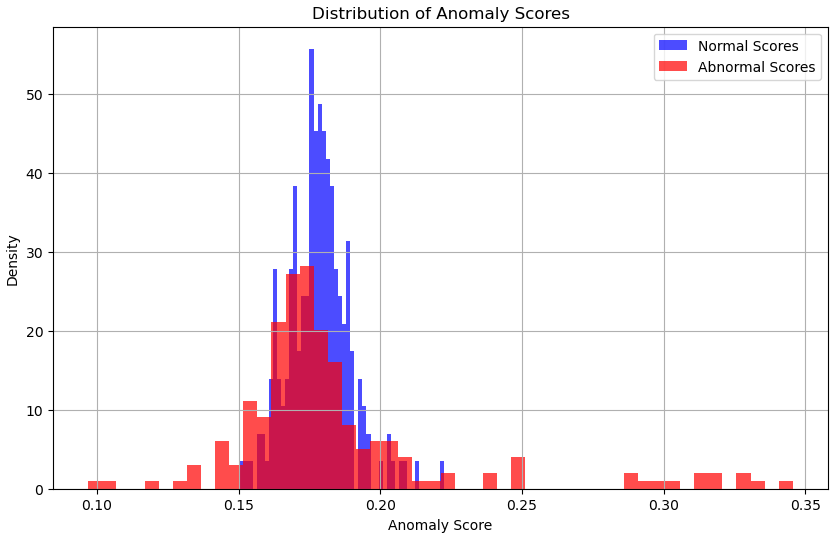

# Anomaly in Degration

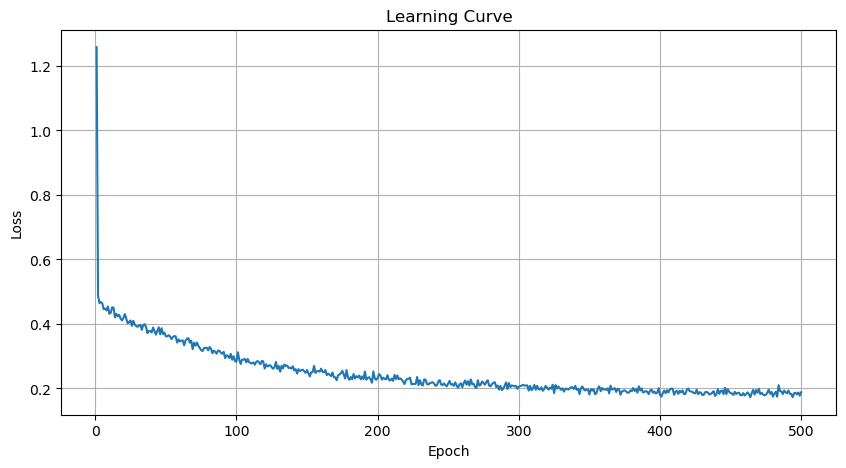


Predicting on test data...


Predicting:   0%|          | 0/7 [00:00<?, ?it/s]


Average score for normal data: 0.2003
Average score for abnormal data: 0.2733


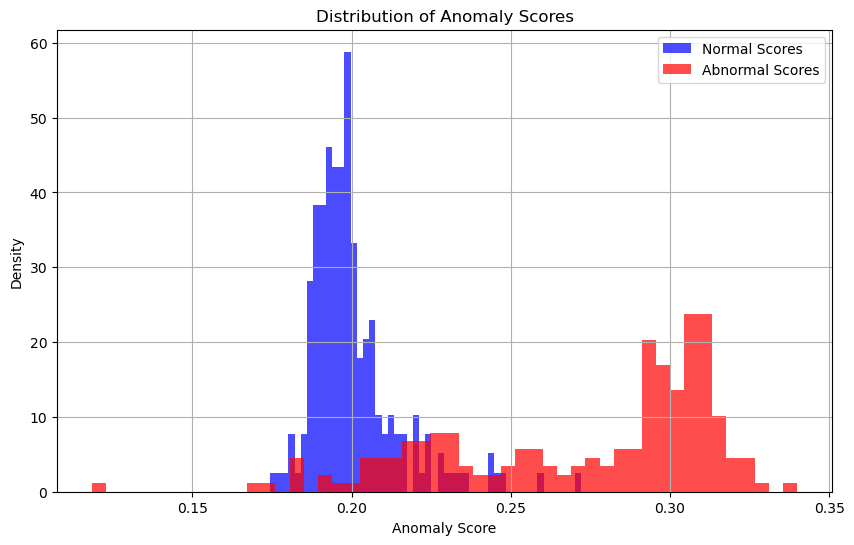

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import random
from tqdm.notebook import tqdm
import math

import warnings
warnings.filterwarnings("ignore")

def normal_data_generator():
    # 第一段 48分鐘
    base = float(np.random.normal(60, 2, size = (1, )))
    series1_1 = (np.random.normal(0, .5, size = (48, )) + base).tolist()
    
    base = float(np.random.normal(70, 2, size = (1, )))
    series2_1 = ([base]*48).copy()
    
    # 第二段 52分鐘
    base = float(np.random.normal(-20, 2, size = (1, )))
    series1_2 = (np.random.normal(0, .01, size = (52, )) + base).tolist()
    
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_2 = (np.random.normal(0, .5, size = (52 + 30, )) + base).tolist()
    
    # 第三段 30分鐘
    base = float(np.random.normal(60, 2, size = (1, )))
    series1_3 = ([base]*30).copy()
    
    series1 = series1_1 + series1_2 + series1_3
    series2 = series2_1 + series2_2
    flag = float(np.random.normal(0, .5, size = (1, )))
    if flag > .5:
        return np.vstack([series1, series2]).T
    else:
        return np.vstack([series2, series1]).T

def abnormal_data_generator():
    base = float(np.random.normal(60, 2, size = (1, )))
    series1 = (np.random.normal(0, .5, size = (48+52+30, )) + base).tolist()
    
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_1 = ([base]*48).copy()
    base = float(np.random.normal(-20, 2, size = (1, )))
    series2_2 = (np.random.normal(0, .01, size = (52, )) + base).tolist()
    base = float(np.random.normal(60, 2, size = (1, )))
    series2_3 = ([base]*30).copy()
    series2 = series2_1 + series2_2 + series2_3
    
    flag = float(np.random.normal(0, .5, size = (1, )))
    if flag > .5:
        return np.vstack([series1, series2]).T
    else:
        return np.vstack([series2, series1]).T

class RelativePositionBias(nn.Module):
    """
    實作論文中提到的相對位置偏置 (Relative Position Bias) 。
    這是一個可學習的查詢表，根據查詢(Query)和鍵(Key)之間的相對距離來提供偏置。
    """
    def __init__(self, num_heads, max_relative_position):
        super().__init__()
        self.num_heads = num_heads
        self.max_relative_position = max_relative_position
        self.relative_attention_bias = nn.Embedding(2 * max_relative_position - 1, num_heads)

    def forward(self, seq_len):
        device = self.relative_attention_bias.weight.device
        q_indices = torch.arange(seq_len, device=device)[:, None]
        k_indices = torch.arange(seq_len, device=device)[None, :]
        relative_indices = k_indices - q_indices
        relative_indices_clipped = relative_indices + self.max_relative_position - 1
        bias = self.relative_attention_bias(relative_indices_clipped)
        return bias.permute(2, 0, 1).unsqueeze(0)


class MultiHeadSelfAttention(nn.Module):
    """
    帶有相對位置偏置的多頭自註意力機制。
    """
    def __init__(self, d_model, n_heads, max_relative_position):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.qkv = nn.Linear(d_model, d_model * 3)
        self.relative_position_bias = RelativePositionBias(n_heads, max_relative_position)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        qkv = self.qkv(x).reshape(batch_size, seq_len, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        bias = self.relative_position_bias(seq_len)
        attn_scores += bias
        attn_probs = torch.softmax(attn_scores, dim=-1)
        context = torch.matmul(attn_probs, v)
        context = context.permute(0, 2, 1, 3).reshape(batch_size, seq_len, self.d_model)
        output = self.out_proj(context)
        return output

class TransformerEncoderLayer(nn.Module):
    """
    論文中描述的 Transformer Encoder 層，採用 Pre-LN (LayerNorm 在前) 結構。
    """
    def __init__(self, d_model, n_heads, dim_feedforward, max_relative_position):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.msa = MultiHeadSelfAttention(d_model, n_heads, max_relative_position)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.GELU(),
            nn.Linear(dim_feedforward, d_model)
        )

    def forward(self, x):
        x = x + self.msa(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class AnomalyBERT(nn.Module):
    """
    完整的 AnomalyBERT 模型。
    """
    def __init__(self, input_dim, window_size, patch_size, d_model, n_heads, n_layers, dim_feedforward):
        super().__init__()
        assert window_size % patch_size == 0, "Window size must be divisible by patch size"
        self.patch_size = patch_size
        num_patches = window_size // patch_size
        self.embedding_layer = nn.Linear(input_dim * patch_size, d_model)
        self.transformer_body = nn.ModuleList([
            TransformerEncoderLayer(d_model, n_heads, dim_feedforward, num_patches)
            for _ in range(n_layers)
        ])
        self.prediction_block = nn.Sequential(
            nn.Linear(d_model, 2048),
            nn.GELU(),
            nn.Linear(2048, patch_size * 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size, window_size, input_dim = x.shape
        patches = x.reshape(batch_size, window_size // self.patch_size, self.patch_size * input_dim)
        embedded_features = self.embedding_layer(patches)
        latent_features = embedded_features
        for layer in self.transformer_body:
            latent_features = layer(latent_features)
        patch_scores = self.prediction_block(latent_features)
        anomaly_scores = patch_scores.reshape(batch_size, window_size, 1)
        return anomaly_scores.squeeze(-1)


class AnomalyBERTAgent:
    """
    封裝 AnomalyBERT 模型訓練和預測流程的 Agent。
    """
    # <--- 新增：接收異常數據生成器 abnormal_generator
    def __init__(self, input_dim, window_size, patch_size, abnormal_generator=None):
        # <--- 新增：儲存生成器
        self.abnormal_generator = abnormal_generator

        # 根據論文附錄 A.2 的模型設定
        self.config = {
            "input_dim": input_dim,
            "window_size": window_size,
            "patch_size": patch_size,
            "d_model": 512,
            "n_heads": 8,
            "n_layers": 6,
            "dim_feedforward": 2048,
            "lr": 1e-4,
            "degradation_col_prob": 0.3,
            # <--- 新增：加入'custom_anomaly'選項並調整機率
            "degradation_type_probs": {
                "soft": 0.4,
                "uniform": 0.1,
                "peak": 0.1,
                "length": 0.2,
                "custom_anomaly": 0.2, # 使用您的生成器產生異常的機率
            }
        }

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.model = AnomalyBERT(
            input_dim=self.config["input_dim"],
            window_size=self.config["window_size"],
            patch_size=self.config["patch_size"],
            d_model=self.config["d_model"],
            n_heads=self.config["n_heads"],
            n_layers=self.config["n_layers"],
            dim_feedforward=self.config["dim_feedforward"]
        ).to(self.device)

        self.optimizer = optim.AdamW(self.model.parameters(), lr=self.config["lr"])
        self.criterion = nn.BCELoss()
        self.epoch_losses = []

    def _degrade_batch(self, batch_x):
        batch_x_degraded = batch_x.clone()
        batch_mask = torch.zeros_like(batch_x_degraded[:, :, 0])
        batch_size, window_size, n_features = batch_x.shape

        for i in range(batch_size):
            cols_to_degrade = random.sample(range(n_features), k=max(1, int(n_features * self.config["degradation_col_prob"])))
            outlier_len = random.randint(int(0.1 * window_size), int(0.3 * window_size))
            if window_size - outlier_len <= 0: continue
            start_idx = random.randint(0, window_size - outlier_len)
            end_idx = start_idx + outlier_len
            batch_mask[i, start_idx:end_idx] = 1.0

            # 選擇降解類型
            degradation_type = np.random.choice(
                list(self.config["degradation_type_probs"].keys()),
                p=list(self.config["degradation_type_probs"].values())
            )

            for col in cols_to_degrade:
                original_slice = batch_x_degraded[i, start_idx:end_idx, col]

                # <--- 新增：處理 custom_anomaly 的邏輯
                if degradation_type == "custom_anomaly" and self.abnormal_generator is not None:
                    # 1. 呼叫您的生成器產生一個異常樣本
                    anomaly_sample_np = self.abnormal_generator()
                    # 2. 轉換為 Tensor 並移至正確設備
                    anomaly_sample_tensor = torch.from_numpy(anomaly_sample_np).float().to(batch_x.device)
                    # 3. 從異常樣本中隨機切出一段
                    anomaly_start = random.randint(0, window_size - outlier_len)
                    anomaly_slice = anomaly_sample_tensor[anomaly_start:anomaly_start + outlier_len, col]
                    # 4. 替換掉原始數據的片段
                    batch_x_degraded[i, start_idx:end_idx, col] = anomaly_slice

                elif degradation_type == "soft":
                    external_idx = random.randint(0, batch_size - 1)
                    external_start = random.randint(0, window_size - outlier_len)
                    external_slice = batch_x[external_idx, external_start:external_start+outlier_len, col]
                    w = random.random()
                    batch_x_degraded[i, start_idx:end_idx, col] = w * original_slice + (1 - w) * external_slice
                elif degradation_type == "uniform":
                    val = torch.mean(batch_x[i, :, col]) + torch.std(batch_x[i, :, col]) * (2*random.random() - 1)
                    batch_x_degraded[i, start_idx:end_idx, col] = val
                elif degradation_type == "peak":
                    if outlier_len > 0:
                        peak_idx = random.randint(start_idx, end_idx - 1)
                        peak_val = torch.mean(batch_x[i, :, col]) + torch.std(batch_x[i, :, col]) * (random.choice([-3, 3]))
                        batch_x_degraded[i, peak_idx, col] += peak_val
                elif degradation_type == "length":
                    new_len = int(outlier_len * random.choice([0.5, 1.5]))
                    if new_len > 0:
                        interp_slice = nn.functional.interpolate(
                            original_slice.view(1, 1, -1), size=new_len, mode='linear', align_corners=False
                        ).view(-1)
                        if new_len < outlier_len:
                            batch_x_degraded[i, start_idx:start_idx+new_len, col] = interp_slice
                        else:
                            batch_x_degraded[i, start_idx:end_idx, col] = interp_slice[:outlier_len]
        return batch_x_degraded, batch_mask

    def train(self, dataloader, epochs):
        self.model.train()
        pbar = tqdm(range(epochs), desc="Training Progress")
        for epoch in pbar:
            epoch_loss_sum = 0.0
            num_batches = 0
            for batch_x, in dataloader:
                batch_x = batch_x.to(self.device)
                degraded_x, target_mask = self._degrade_batch(batch_x)
                degraded_x, target_mask = degraded_x.to(self.device), target_mask.to(self.device)
                self.optimizer.zero_grad()
                pred_scores = self.model(degraded_x)
                loss = self.criterion(pred_scores, target_mask)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()
                epoch_loss_sum += loss.item()
                num_batches += 1
            avg_epoch_loss = epoch_loss_sum / num_batches
            self.epoch_losses.append(avg_epoch_loss)
            pbar.set_description(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.6f}")
            if (epoch + 1) % 10 == 0:
                clear_output(wait=True)
                fig, ax = plt.subplots(figsize=(10, 5))
                ax.plot(range(1, epoch + 2), self.epoch_losses)
                ax.set_xlabel("Epoch")
                ax.set_ylabel("Loss")
                ax.set_title("Learning Curve")
                ax.grid(True)
                plt.show()

    def predict(self, dataloader):
        self.model.eval()
        all_scores = []
        with torch.no_grad():
            for batch_x, in tqdm(dataloader, desc="Predicting"):
                batch_x = batch_x.to(self.device)
                pred_scores = self.model(batch_x)
                sample_scores = torch.mean(pred_scores, dim=1)
                all_scores.append(sample_scores.cpu().numpy())
        return np.concatenate(all_scores)

if __name__ == '__main__':
    # Step 2: 準備數據
    WINDOW_SIZE = 130
    N_FEATURES = 2
    PATCH_SIZE = 10

    # 訓練數據 (只用正常數據)
    print("Generating training data...")
    train_data = [normal_data_generator() for _ in range(1000)]
    train_tensor = torch.tensor(np.array(train_data), dtype=torch.float32)
    train_dataset = TensorDataset(train_tensor)
    train_loader = DataLoader (train_dataset, batch_size=32, shuffle=True)

    # 測試數據 (正常+異常)
    print("Generating test data...")
    n_test_normal = 200
    n_test_abnormal = 200
    test_data_normal = [normal_data_generator() for _ in range(n_test_normal)]
    test_data_abnormal = [abnormal_data_generator() for _ in range(n_test_abnormal)]
    test_data = test_data_normal + test_data_abnormal
    test_tensor = torch.tensor(np.array(test_data), dtype=torch.float32)
    test_dataset = TensorDataset(test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # <--- 新增：在建立 agent 時傳入生成器
    # Step 3: 建構 Agent 並訓練
    agent = AnomalyBERTAgent(
        input_dim=N_FEATURES,
        window_size=WINDOW_SIZE,
        patch_size=PATCH_SIZE,
        abnormal_generator=abnormal_data_generator
    )
    agent.train(dataloader=train_loader, epochs=500)

    # Step 4: 預測並評估
    print("\nPredicting on test data...")
    all_scores = agent.predict(dataloader=test_loader)

    normal_scores = all_scores[:n_test_normal]
    abnormal_scores = all_scores[n_test_normal:]

    print(f"\nAverage score for normal data: {np.mean(normal_scores):.4f}")
    print(f"Average score for abnormal data: {np.mean(abnormal_scores):.4f}")

    # Step 5: 畫出分數分佈圖
    plt.figure(figsize=(10, 6))
    plt.hist(normal_scores, bins=50, alpha=0.7, label='Normal Scores', color='blue', density=True)
    plt.hist(abnormal_scores, bins=50, alpha=0.7, label='Abnormal Scores', color='red', density=True)
    plt.xlabel("Anomaly Score")
    plt.ylabel("Density")
    plt.title("Distribution of Anomaly Scores")
    plt.legend()
    plt.grid(True)
    plt.show()

# 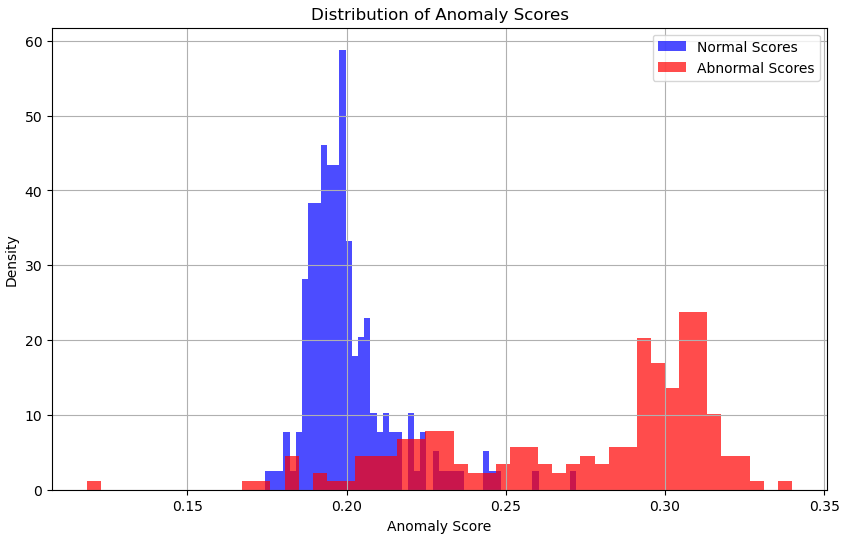